# Frame Analysis F1 Score Generator

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook tests how good a trained frame-by-frame analysis model is by generating an F1 score for a dataset of bicep curls. 

Input: tuples of the bicep curl videos and trained frame analysis models.

## TOC:
0. [Import Libraries & Setup](#0.-Import-Libraries-&-Setup)
1. [Setup Testing Set](#1.-Setup-Testing-Set)
2. [Evaluate Models](#2.-Evaluate-Models)
    * [Linear SVC](#SVC-Model)
    * [Nearest Neighbours](#KNC-Model)
    * [Gaussian Naive Bayes](#Gaussian-NB-Model)
    * [Neural Network](#Neural-Network-Model)

# 0. Import Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp

import math

import os
import pickle

from joblib import load

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
svc_model = load('svc-bicep-curl-mistakes.joblib')
knc_model = load('knc-bicep-curl-mistakes.joblib')
mlp_model = load('mlp-bicep-curl-mistakes.joblib')
gnb_model = load('gnb-bicep-curl-mistakes.joblib')

all_videos = pickle.load(open('all-bicep-curls.dump', 'rb'))

In [3]:
len(all_videos)

85

# 1. Setup Testing Set

In [4]:
X = []
y = []

for i in all_videos:
    X.append(i[1])
    y.append(i[0])

In [5]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_test), len(y_test))

29 29


The same seed is used as in label-frames notebook, so the same test set is created. We don't need the training set in this notebook, the training set is used in label-frames.

In [6]:
y_test # A list of the labels

['shoulder',
 'good',
 'shoulder',
 'good',
 'good',
 'shoulder',
 'good',
 'good',
 'good',
 'shoulder',
 'elbow',
 'elbow',
 'elbow',
 'shoulder',
 'elbow',
 'elbow',
 'elbow',
 'shoulder',
 'elbow',
 'elbow',
 'good',
 'good',
 'elbow',
 'good',
 'good',
 'shoulder',
 'good',
 'elbow',
 'elbow']

# 2. Evaluate Models

In [7]:
labels = ['elbow', 'good', 'shoulder']
    
def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                   'Accuracy': acc, 
                   'Precision': precision, 
                   'Recall': recall,
                   'F1 Score': f1}

    if display_matrix:
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()

    return model_metrics

Using the three features extracted in label-frames:
   - Hip angle (via keypoints 11, 23, 25)
   - Elbow-hip angle (via keypoints 13, 11, 23)
   - Bicep angle (via keypoints 11, 13, 15)
   
First we have to set up the functions that calculate these heuristics.

In [8]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [9]:
# Function to search through all the frames in the video and label whole video with feature extraction
# INPUT: list of frames with the coordinates of the keypoints (landmarks) in each frame and the trained model
# OUTPUT: string of the label outputted by the trained model
def label_video(frames, model):
    # By default, the video is labelled as good until a frame with a mistake is found
    label = 'good'
    
    for f in frames:
        # Setup heuristic values for input into model
        heuristics = {}
        
        # Note: the order of these should be same as the order in .filter of label-frames notebook
        heuristics['bicep_angle'] = get_angle(f['coordinates'], 11, 13, 15)
        heuristics['elbow_hip_angle'] = get_angle(f['coordinates'], 13, 11, 23)
        heuristics['hip_angle'] = get_angle(f['coordinates'], 11, 23, 25)

        prediction = model.predict(pd.DataFrame([heuristics]))[0]
        
        # Frame with a mistake is found
        if prediction != 'good':
            return prediction
        
    return label

## SVC Model

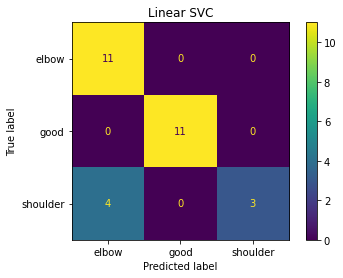

{'Classifier': 'Linear SVC',
 'Accuracy': 0.8620689655172413,
 'Precision': 0.9111111111111111,
 'Recall': 0.8095238095238094,
 'F1 Score': 0.8620689655172413}

In [10]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, svc_model))
    
evaluate_model('Linear SVC', y_pred, True)

## KNC Model

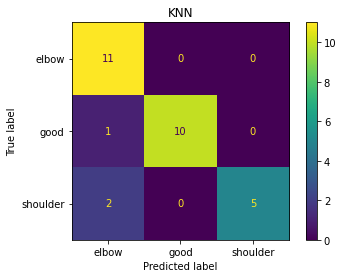

{'Classifier': 'KNN',
 'Accuracy': 0.896551724137931,
 'Precision': 0.9285714285714285,
 'Recall': 0.8744588744588745,
 'F1 Score': 0.896551724137931}

In [11]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, knc_model))
    
evaluate_model('KNN', y_pred, True)

## Gaussian NB Model

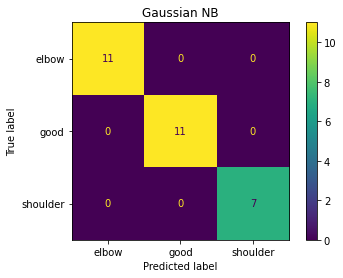

{'Classifier': 'Gaussian NB',
 'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1 Score': 1.0}

In [12]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, gnb_model))
    
evaluate_model('Gaussian NB', y_pred, True)

In [13]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       elbow       1.00      1.00      1.00        11
        good       1.00      1.00      1.00        11
    shoulder       1.00      1.00      1.00         7

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



## Neural Network Model

C:\Users\abid5.000\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


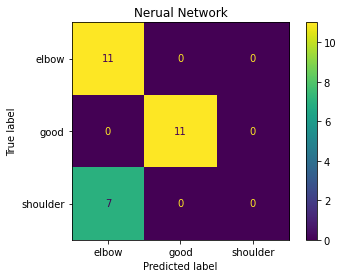

{'Classifier': 'Nerual Network',
 'Accuracy': 0.7586206896551724,
 'Precision': 0.5370370370370371,
 'Recall': 0.6666666666666666,
 'F1 Score': 0.7586206896551724}

In [14]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, mlp_model))
    
evaluate_model('Nerual Network', y_pred, True)